In [1]:
# Sam Brown
# sam_brown@mines.edu
# Description: Classifying high vs low pre-slip area events using residual data from GPS stations.
# Date: 2025-03-26

import sys
sys.path.append("/Users/sambrown04/Documents/SURF/whillans-surf/notebooks/SURF")

# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import butter, filtfilt
from scipy.integrate import simps
import scipy.signal

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import my_lib.funcs

# Set path to event files
evts_path = "/Users/sambrown04/Documents/SURF/Events/2010_2010Events2stas" 

For each event we will want the following features:
    - average serverity of the slip (averaged among stations)
    - hour of day that the event starts (1-24)
    - average station residual for this point

First we need to form a dataframe that has the features (average severity, hour, average station res) and target (pre-slip area) for each event.

In [7]:
# storing events in a data frame for use

events_list = my_lib.funcs.load_evt(evts_path)

Now we will preprocess this data 

In [11]:
new_features = my_lib.funcs.extract_event_features(events_list)

In [13]:
new_features[1].head(10)
# len(new_features)

,station,pre-slip_area,slip_severity,peak_time,total_delta
0,la02x,110.442874,1.445604e-06,6975.0,0.454037
1,la09x,2.173707,2.695754e-07,255.0,0.163290


In [14]:
# Now we have the new_features list. To create a data set that we can train and test on, we need to summarize these values for each event. That is, we need to average the slip area and severity for each event.
df_model = pd.DataFrame(
    data = np.nan,
    index = range(len(new_features)),
    columns=['slip_area','slip_severity','hour', 'avg_res', 'target']
)

df_model.head()

,slip_area,slip_severity,hour,avg_res,target
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [15]:
for i, features in enumerate(new_features): # Add the mean area and severity to our data frame
    df_model.loc[i, 'slip_area'] = features['pre-slip_area'].mean()
    df_model.loc[i, 'slip_severity'] = features['slip_severity'].mean()

Text(0, 0.5, 'slip severity (2nd deriv)')

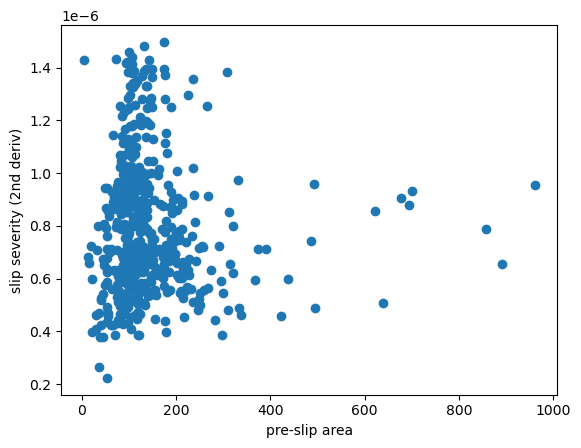

In [16]:
plt.scatter(df_model['slip_area'], df_model['slip_severity'])
plt.xlabel('pre-slip area')
plt.ylabel('slip severity (2nd deriv)')

Now we just need to add the hour of day to each event, the average residual for the event, and encode a 0 or 1 for a small vs large slip area. 

In [18]:
# Add hour of day to each event
df_model.head()

,slip_area,slip_severity,hour,avg_res,target
0,155.048268,5.582876e-07,NaN,NaN,NaN
1,56.308290,8.575898e-07,NaN,NaN,NaN
2,89.240155,4.914228e-07,NaN,NaN,NaN
3,172.138300,8.740249e-07,NaN,NaN,NaN
4,119.256765,4.746864e-07,NaN,NaN,NaN


In [19]:
start_times = [] # Define start times
for event in events_list:
    start_times.append(event['time'][0])

In [20]:
# Put start times into data frame
start_times_dt = pd.to_datetime(start_times)
start_hours = start_times_dt.hour
df_model['hour'] = start_hours

In [21]:
df_model['target'] = (df_model['slip_area'] > 200).astype(int) # Encode the target variable

Random Forest, SVM

In [23]:
X = df_model[['slip_severity', 'hour']]
y = df_model['target']

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [27]:
y_pred = rf_model.predict(X_test)

# 7. Evaluate the results
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[105  30]
 [ 11  13]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.78      0.84       135
           1       0.30      0.54      0.39        24

    accuracy                           0.74       159
   macro avg       0.60      0.66      0.61       159
weighted avg       0.81      0.74      0.77       159

Accuracy Score: 0.7421383647798742
